### Nonlinear Function

Given a $\phi$ and $\phi^{-1}$ (trained in Quantum autoencoder) such that $\phi^{-1}\circ\phi|\alpha\rangle = |\alpha\rangle$ and $dim(\phi|\alpha\rangle) < dim(|\alpha\rangle)$, we want to find a function $f$ such that $\phi^{-1}\circ f\circ\phi|\alpha_k\rangle = |\alpha_{k+1}\rangle$.

In [2]:
import matplotlib.pyplot as plt         
import tensorflow as tf
import numpy as np
import os
import pandas as pd

import sys

sys.path.append('..')
from utils import *
sys.path.remove('..')


#Some GPU configuration
#Always uses the 1st GPU avalible (if avalible) unless 1st line is uncommented, in which case no GPU is used

#tf.config.set_visible_devices([], 'GPU') #uncomment to set tensorflow to use CPU
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) != 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
elif len(physical_devices) == 0:
    print("Warning: No GPU detected.  Running tensorflow on CPU")

In [ ]:
Phi = tf.keras.models.load_model('../Autoencoder/Autoencoder_Trials/models/trial25e1000Phi.h5', compile=False)
Phi_inv = tf.keras.models.load_model('../Autoencoder/Autoencoder_Trials/models/trial25e1000Phi_inv.h5', compile=False)

In [4]:
def predict_single_timestep(state, ideal_compression_3D=False, compression_phi=True, decompression_phi_inv=True):

    if ideal_compression_3D:
        assert (len(state) == 4), "State must be a four dimensional vector to be compressed"
        state = ideal_phi_3D(state)
        return ideal_phi_3D_inv(NonlinearEvolution(np.array([state,])).numpy()[0])
    if compression_phi:
        assert (len(state) == 4), "State must be a four dimensional vector to be compressed"
        state = Phi(np.array([state,]))
        if decompression_phi_inv:
            return Phi_inv(NonlinearEvolution(state))
        else:
            return NonlinearEvolution(state)
    
    assert (len(state)==3), "State must be three dimensional if not being compressed"
        
    return NonlinearEvolution(np.array([state,])).numpy()[0]
    

In [5]:
def L2_loss(y_true, y_pred):
    return tf.norm(y_true-y_pred, ord=2, axis=-1)

def L2_with_unity_loss(y_true, y_pred):
    '''L2 loss augmented with extra loss for not having a norm of 1'''
    return tf.norm(y_true-y_pred, ord=2, axis=-1) + tf.abs(1. - tf.norm(y_pred, ord=2, axis=-1))

def ideal_phi_3D(state):
    assert (len(state)==4),'State must be 4 dimensions to compress to 3'
    r1 = np.sqrt(state[0]*state[0] + state[1]*state[1])
    r2 = np.sqrt(state[2]*state[2]+state[3]*state[3])
    phi1 = np.math.atan2(state[1],state[0])
    phi2 = np.math.atan2(state[3],state[2])
    return np.array([r1, r2, phi2-phi1])

def ideal_phi_3D_inv(state):
    assert (len(state) == 3),'Compressed state must be 3 dimensions to be decompressed'
    alpha = state[0]
    beta = 0.
    gamma = state[1]*np.cos(state[2])
    delta = state[1]*np.sin(state[2])
    return np.array([alpha, beta, gamma, delta])

In [6]:
def get_evolution_data(evolution_data, ideal_pre_compress_3D=False, pre_compress_phi=False):
    '''Read in evolution data from a csv file
    
    PARAMS:
    -------
    str evolution_data: Path to evolution datafile we wish to read
    bool ideal_pre_comrpess_3D: If true, uses ideal compression functions to 
                                  compress evolution data into specified dimension
    bool pre_compress_phi: If true, use the Phi neural net model to compress
                           evolution data
    
    RETURNS:
    --------
    tf.data.Dataset: Shuffled dataset of evolution values
    '''

    evolution_file = evolution_data
    
    with open(evolution_file, 'r') as f:
        data = np.genfromtxt(f, delimiter=',', skip_header=1)[:,1:]
        
        if ideal_pre_compress_3D:
            data = np.array([ideal_phi_3D(x) for x in data])
        elif pre_compress_phi:
            data = Phi(data)
 
    
        pre_evolution = np.empty([len(data)-1, len(data[0])])
        post_evolution = np.empty([len(data)-1, len(data[0])])
   
        pre_evolution[0] = data[0]
        
        for i,k in enumerate(data[1:-1]):
            pre_evolution[i+1] = k
            post_evolution[i] = k
            
        post_evolution[-1] = data[-1]
        

        ds = tf.data.Dataset.from_tensor_slices((pre_evolution, post_evolution))
            
        
        return ds.shuffle(100000, reshuffle_each_iteration=True)
    
    
#Train on entire evolutions, not just step-to-step?
#TODO: read in initial conditions randomly, not just sequentially
def get_multiple_evolutions(datadir, num_evolutions, train_evolutions, ideal_pre_compress_3D=False, pre_compress_phi=False):
    '''Read in the evolution of multiple initial conditions at once.  Each initial condition should 
    have its own csv file and be named in the format "evolution{}.csv", where {} indicates an integer
    
    PARAMS:
    -------
    str datadir: Path to directory containing evolution files.
    int num_evolutions: The number of initial conditions to read in.
    int train_evolutions: The number of initial conditions that should be treated as 
                          training evolutions
    
    RETURNS:
    --------
    (tf.data.Dataset, tf.data.Dataset): A tuple of the training and validation datasets, respectivley.
    '''
    
    pre_evolution = []
    post_evolution = []
    
    #Read training data
    for i in range(train_evolutions):
        with open(datadir+'evolution{}.csv'.format(i), 'r') as f:
            data = np.genfromtxt(f, delimiter=',', skip_header=1)[:,1:]
            
            if ideal_pre_compress_3D:
                data = [ideal_phi_3D(x) for x in data]
            elif pre_compress_phi:
                data = Phi(data)
            
            pre_evolution.append(data[0])
            
            for k in data[1:-1]:
                pre_evolution.append(k)
                post_evolution.append(k)
            
            post_evolution.append(data[-1])
            
    train = tf.data.Dataset.from_tensor_slices((pre_evolution, post_evolution))
    
    
    #Read test data
    pre_evolution = []
    post_evolution = []
    
    for i in range(train_evolutions, num_evolutions):
        with open(datadir+'evolution{}.csv'.format(i), 'r') as f:
            data = [x.strip().split(',')[1:] for x in f.readlines()]
            data = [[float(y) for y in x] for x in data]
            
            if pre_compress_3D:
                data = [ideal_phi_3D(x) for x in data]
            
            pre_evolution.append(data[0])
            
            for k in data[1:-1]:
                pre_evolution.append(k)
                post_evolution.append(k)
            
            post_evolution.append(data[-1])
            
    test = tf.data.Dataset.from_tensor_slices((pre_evolution, post_evolution))
    
    return train.shuffle(100000, reshuffle_each_iteration=True), test.shuffle(100000, reshuffle_each_iteration=True)

In [69]:
inputs = tf.keras.Input(shape=3)


nonlinear_layer_1 = tf.keras.layers.Dense(64, activation='selu', name='nonlinear_layer_1')(inputs)
nonlinear_layer_2 = tf.keras.layers.Dense(256, activation='selu', name='nonlinear_layer_2')(nonlinear_layer_1)
nonlinear_layer_3 = tf.keras.layers.Dense(512, activation='selu', name='nonlinear_layer_3')(nonlinear_layer_2)
nonlinear_layer_4 = tf.keras.layers.Dense(512, activation='selu', name='nonlinear_layer_4')(nonlinear_layer_3)
nonlinear_layer_5 = tf.keras.layers.Dense(256, activation='selu', name='nonlinear_layer_5')(nonlinear_layer_4)
nonlinear_layer_6 = tf.keras.layers.Dense(64, activation='selu', name='nonlinear_layer_6')(nonlinear_layer_5)
evolved = tf.keras.layers.Dense(3, activation='selu', name='evolved_state_layer')(nonlinear_layer_6)

NonlinearEvolution = tf.keras.Model(inputs=inputs, outputs=evolved)

In [70]:
train_data = get_evolution_data('../../QuantumTeam/data/long_evolutions_(testing_timesteps)/big_evolve0p01.csv', pre_compress_phi=True)
val_data = train_data.skip(int(0.8*100000)).batch(int(0.2*100000))
train_data = train_data.take(int(0.8*100000)).batch(int(0.8*100000))

#train_data, val_data = get_multiple_evolutions('../../QuantumTeam/data/50inits_dt0p1/', 50, 40, pre_compress_3D=True)
#train_data = train_data.batch(80000)
#val_data = val_data.batch(20000)

In [75]:
NonlinearEvolution.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.0001), loss=L2_loss, metrics=['mse', 'mae'])

In [ ]:
history = NonlinearEvolution.fit(train_data, validation_data=val_data, epochs=500)

In [73]:
write_history(history, NonlinearEvolution,loss='L2_loss',batch_size='80000', other_info={'dataset':'big_evolve0p01.csv'})

'./datafiles/trial30.data'

In [77]:
append_history(history, trial=30, params={'Learning Rate':.0001})

In [78]:
NonlinearEvolution.save('./models/trial30e1000.h5')

In [8]:
NonlinearEvolution = tf.keras.models.load_model('./models/trial30e1000.h5', compile=False)

In [7]:
predict_single_timestep([1., 0., 0., 0.])

array([0.71280563, 0.        , 0.0636726 , 0.33711895])

## Visualizations

In [16]:
import qutip as qt


def predict_evolution(initial_cond, save_prediction=False, saved_name='./predicted_evolutions/newtest.csv', timesteps=1000):
    if type(initial_cond) == str:
        initial_cond = np.genfromtxt(initial_cond, delimiter=',', skip_header=1)[0,1:]
    
    if len(initial_cond)==4:
        initial_cond=Phi(np.array([initial_cond,])).numpy()[0]
    
    learned_evolution=np.empty([timesteps, 3])
    learned_evolution[0] = initial_cond
    
    for i in range(1,timesteps):
        learned_evolution[i] = predict_single_timestep(learned_evolution[i-1], compression_phi=False, decompression_phi_inv=False)
    
    learned_evolution=Phi_inv(learned_evolution).numpy()
    
    if save_prediction:
        pd.DataFrame(learned_evolution).to_csv(saved_name)
        
    return learned_evolution


def plot_dynamics(truth, predicted, savefig=False, timerange=500, 
                  phispace=False, figname='dynamics.png', figsize=(12,24),
                  fontsize=16):
    fig, ax = plt.subplots(3,1,figsize=(12,24))
    
    
    FONTSIZE=fontsize
    plt.rc('font', size=FONTSIZE)
    plt.rc('axes', titlesize=FONTSIZE,labelsize=FONTSIZE)
    plt.rc('legend', fontsize=FONTSIZE)
    plt.rc('xtick', labelsize=FONTSIZE)
    plt.rc('ytick', labelsize=FONTSIZE)
    plt.rc('figure', titlesize=FONTSIZE)
    
    
    if not phispace:
        r1 = np.sqrt(truth[:timerange,1]**2 + truth[:timerange,2]**2)
        r2 = np.sqrt(truth[timerange,3]**2 + truth[:timerange,4]**2)
        theta = np.arctan2(truth[:timerange,4],truth[:timerange,3]) - np.arctan2(truth[:timerange,2],truth[:timerange,1])

        r1l = np.sqrt(predicted[:timerange,1]**2 + predicted[:timerange,2]**2)
        r2l = np.sqrt(predicted[:timerange,3]**2 + predicted[:timerange,4]**2)
        thetal = np.arctan2(predicted[:timerange,4],predicted[:timerange,3]) - np.arctan2(predicted[:timerange,2],predicted[:timerange,1])
        
        ax[0].plot(truth[:timerange,0], r1, label='True')
        ax[0].plot(predicted[:timerange,0], r1l, ls='--', label='Predicted')

        ax[1].plot(truth[:timerange,0],r2)
        ax[1].plot(predicted[:timerange,0],r2l, ls='--')

        ax[2].plot(truth[:timerange,0],theta)
        ax[2].plot(predicted[:timerange,0],thetal, ls='--')

        ax[0].legend()
        ax[0].set_title(r'$r_1 = \sqrt{\alpha^2+\beta^2}$')
        ax[1].set_title(r'$r_2 = \sqrt{\gamma^2+\delta^2}$')
        ax[2].set_title(r'$\theta = \arctan\left(\frac{\delta}{\gamma}\right) - \arctan\left(\frac{\beta}{\alpha}\right)$')

        ax[2].set_xlabel('Timestep')
        
    else:
        compressed_truth = Phi(truth[:,1:]).numpy()
        compressed_pred = Phi(predicted[:,1:]).numpy()

        ax[0].plot(truth[:timerange,0], compressed_truth[:timerange,0], label='True')
        ax[0].plot(predicted[:timerange,0], compressed_pred[:timerange,0], ls='--',label='Predicted')

        ax[1].plot(truth[:timerange,0],compressed_truth[:timerange,1])
        ax[1].plot(predicted[:timerange,0],compressed_pred[:timerange,1], ls='--')

        ax[2].plot(truth[:timerange,0],compressed_truth[:timerange,2])
        ax[2].plot(predicted[:timerange,0],compressed_pred[:timerange,2], ls='--')

        ax[0].legend()
        ax[0].set_title(r'$\phi|\alpha\rangle[0]$')
        ax[1].set_title(r'$\phi|\alpha\rangle[1]$')
        ax[2].set_title(r'$\phi|\alpha\rangle[2]$')
        ax[2].set_xlabel('Timestep')
        
    if savefig:
        fig.savefig(figname, bbox_inches='tight', transparent=False)
        
    
        
#Create images to be used for animations of the evolution
#VERY SLOW, took about 25 minutes to create 1000 images on my laptop

def create_animation_frames(truth, predicted, framedir='./anim/', timesteps=500):

    b = qt.Bloch()


    b.vector_color = ['g', '#000000']
    b.point_marker = ['o']

    all_true_states = []
    all_learned_states = []

    for i in range(timesteps):
        b.clear()

        #Have to reset colors each time since all true states are plotted then all predicted states
        b.point_color = [x for x in ['g', '#000000'] for k in range(i+1)]

        #Plot true evolution in green

        state = np.array([truth[i,1]+truth[i,2]*1j, truth[i,3]+truth[i,4]*1j])
        state = qt.Qobj(state)
        b.add_states([state])
        all_true_states.append(state)
        b.add_states(all_true_states, kind='point')

        #Plot learned evolution in black

        state = np.array([predicted[i,1]+predicted[i,2]*1j, predicted[i,3]+predicted[i,4]*1j])
        state = qt.Qobj(state)
        b.add_states([state])
        all_learned_states.append(state)
        b.add_states(all_learned_states, kind='point')
        
        b.save(dirc=framedir)

In [21]:
data = np.genfromtxt("/storage/Documents/programming/machine_learning/BYU/git/QuantumTeam/data/long_evolutions_(testing_timesteps)/big_evolve0p01.csv", delimiter=",", skip_header=1)
learned = np.genfromtxt('./predicted_evolutions/learnedt30_nodecompression.csv', delimiter=",", skip_header=1)

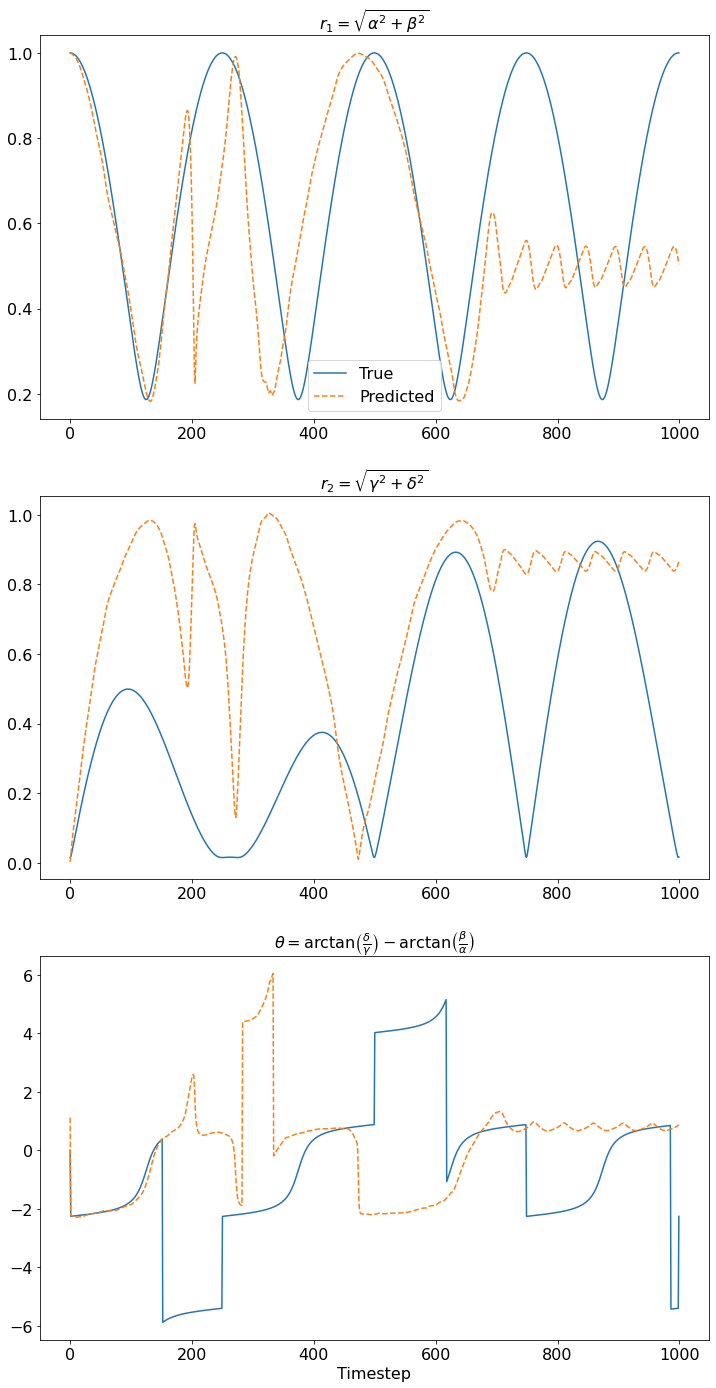

In [22]:
plot_dynamics(data, learned, phispace=False, savefig=False, timerange=1000)

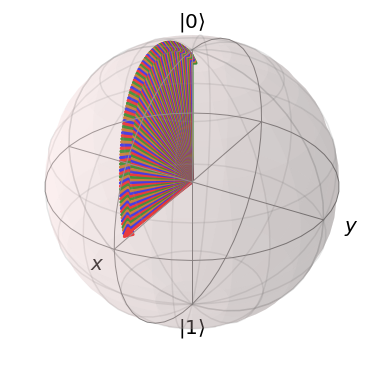

In [83]:
#The actual evolution

bloch = qt.Bloch()

for i in range(100):
    state = np.array([data[i,1]+data[i,2]*1j, data[i,3]+data[i,4]*1j])
    bit=qt.Qobj(state)
    bloch.add_states([bit])
    
bloch.render()

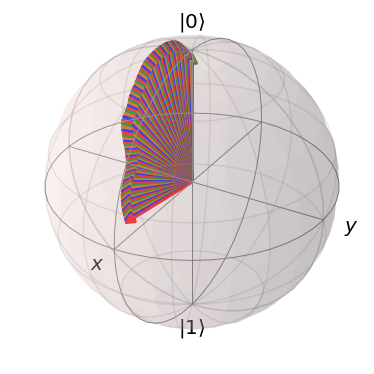

In [201]:
#The predicted evolution

bloch = qt.Bloch()

for i in range(100):
    state = np.array([learned[i,1]+learned[i,2]*1j, learned[i,3]+learned[i,4]*1j])
    bit=qt.Qobj(state)
    bloch.add_states([bit])
    
bloch.render()

### Old/unused functions

May still be useful as refrence/figure out what we were doing before, but not immidietley useful to the program and just cluttering up the notebook otherwise

In [20]:
##NOTE: The 2D compression tools do not work, only the 3D ones
def ideal_phi_2D(states):
    theta = np.math.atan2(states[1],states[0]) - np.math.atan2(states[3],states[2])
    r = np.sqrt(states[0]*states[0]+states[1]*states[1])
    return np.array([r, theta])

def ideal_phi_2D_inv(compressed):
    r, theta = compressed[0], compressed[1]
    
    alpha = r*np.cos(theta)
    beta = r*np.sin(theta)
    gamma = np.sqrt(1-r*r)
    delta = 0.
    return np.array([alpha, beta, gamma, delta])





#These compressions fail because sign information on the fourth dimension is lost w/ the square root

def ideal_phi_3D(states):
    return np.array([states[0], states[1], states[2]])

def ideal_phi_3D_inv(compressed):
    diff = 1-compressed[0]*compressed[0]-compressed[1]*compressed[1]-compressed[2]*compressed[2]
    if diff >=0.:
        fourth_component = np.sqrt(diff)
    else:
        fourth_component = 0.
    return np.array([compressed[0], compressed[1], compressed[2], fourth_component])


def get_relative_phase(vector):
    '''Returns the relative phase between
    the two complex components of a two
    complex dimensional vector
    Assumes the vector is passed in as a 
    four dimensional real row vector of form
    [real1, imag1, real2, imag2]
    '''
    

    #Tensorflow likes to return a list of a single
    #element sometimes, which breaks this function
    #This does not happen during training, only when
    #manually run on a single vector
    if vector.shape == (4,):
        return tf.atan2(vector[1], vector[0])%(2*np.pi) - tf.atan2(vector[3], vector[2])%(2*np.pi)

    return tf.atan2(vector[:,1],vector[:,0])%(2*np.pi) - tf.atan2(vector[:,3],vector[:,2])%(2*np.pi)
